In [1]:
import numpy as np
import pandas as pd

from enn.enn import ENN
from pylmnn import LargeMarginNearestNeighbor as LMNN
from seaborn import heatmap
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, mean_absolute_error, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC

In [2]:
white_wine = pd.read_csv('data/winequality-white.csv', sep=';')
white_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
red_wine = pd.read_csv('data/winequality-red.csv', sep=';')
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
print(white_wine.shape)
print(white_wine.dropna().shape)

(4898, 12)
(4898, 12)


In [5]:
print(red_wine.shape)
print(red_wine.dropna().shape)

(1599, 12)
(1599, 12)


Первый плюс - в данных нету пробелов.

In [6]:
white_quality = white_wine['quality'].groupby(white_wine['quality']).count()
red_quality = red_wine['quality'].groupby(red_wine['quality']).count()

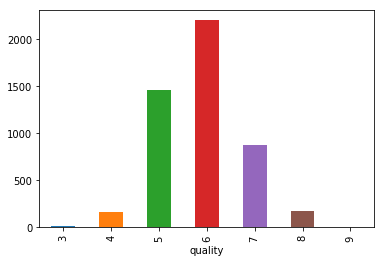

In [7]:
white_quality.plot('bar');

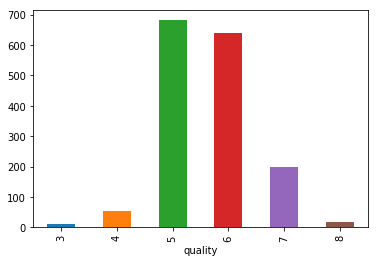

In [8]:
red_quality.plot('bar');

In [9]:
corr_matrix_white = white_wine.drop('quality', axis=1).corr()

In [10]:
corr_matrix_red = red_wine.drop('quality', axis=1).corr()

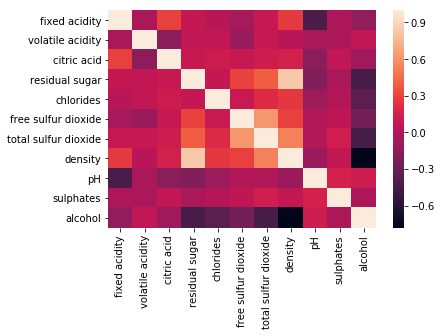

In [11]:
heatmap(corr_matrix_white);

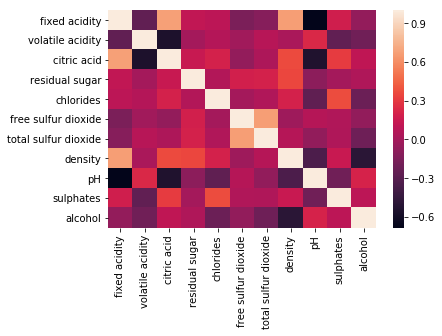

In [12]:
heatmap(corr_matrix_red);

Второй плюс, в данных нету признаков, которые зависимы друг от друга, значит ничего небудет мешать правильной постройки модели.

Сначала попробуем добиться максимального предсказания для белого вина. Так как эту задачу можно рассматривать двумя способами: как задачу класификации и как задачу регресии я попробую проверить оба варианта. Сначала поработаем с задачей регресии.

In [13]:
X = white_wine.drop(['quality'], axis=1).values
y = white_wine['quality'].values

In [14]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3,random_state=1)

In [15]:
knn_regression = KNeighborsRegressor(n_neighbors=7)

In [16]:
knn_regression.fit(X_train, y_train);

In [17]:
knn_regreession_predict = knn_regression.predict(X_test)

In [18]:
print("Ошибка прогноза для отложеной выборки(mean square error) : ", mean_squared_error(y_test, knn_regreession_predict))
print("ошибка прогноза для отложеной выборки(mean absolute error): ", mean_absolute_error(y_test, knn_regreession_predict))

Ошибка прогноза для отложеной выборки(mean square error) :  0.6428849090656671
ошибка прогноза для отложеной выборки(mean absolute error):  0.6381924198250729


Метрики в задачах регресии меряют ошибку между истинными значениями и тем, что предсказывает модель. Как видно у нас это очень большие разница на данный момент. Моя задача сделать эти значения как можно меньше. Для этого нужно подобрать параметры, которые минимизируют эту ошибку. Я решила подобрать такие параметры:количество соседей, метрика, которая используется для измерения расстояния между соседями и алгоритм нахождения соседей. Сделаю это при помощи GridSearch.

In [19]:
KNNparam = {'n_neighbors':range(2, 10),
            'metric':["euclidean", "manhattan", "chebyshev", "minkowski"]}
knn_regression = KNeighborsRegressor()
knn_grid_regression = GridSearchCV(knn_regression, KNNparam, cv=5, n_jobs=-1)

In [20]:
knn_grid_regression.fit(X_train, y_train);

In [21]:
print(f'Лучшие параметры: {knn_grid_regression.best_params_}')

Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 9}


In [22]:
metric = knn_grid_regression.best_params_['metric']
n_neighbors = knn_grid_regression.best_params_['n_neighbors']

In [23]:
knn_regression_best = KNeighborsRegressor(n_neighbors=n_neighbors, metric=metric)

In [24]:
knn_regression_best.fit(X_train, y_train);

In [25]:
knn_regression_best_predict = knn_regression_best.predict(X_test)

In [26]:
print("Ошибка прогноза для отложеной выборки после подборки параметров(mean square error) : ", mean_squared_error(y_test, knn_regression_best_predict))
print("Ошибка прогноза для отложеной выборки после подборки параметров(mean absolute error): ", mean_absolute_error(y_test, knn_regression_best_predict))

Ошибка прогноза для отложеной выборки после подборки параметров(mean square error) :  0.6078945158310237
Ошибка прогноза для отложеной выборки после подборки параметров(mean absolute error):  0.6228269085411943


Видно, что ошибка стала даже меньше,но она всё равно большая. Если вспомнить первый график, то можно сделать вывод, что данные не сбалансированы. Это может оказаться большой проблемой. Попробую сбалансировать их. Это можно сделать двумя способами. Обрезать лишние данные или добавить там, где не хватает. Я лучше добавилю данных там, где не хватает, потому что есть такие оценки качества, которых совсем мало и если все данные подгонять к ним у меня практически ничего не останется в выборке.

In [27]:
white3=white_wine[white_wine['quality']==3]
white3=pd.concat([white3]*120)
white4=white_wine[white_wine['quality']==4]
white4=pd.concat([white4]*14)
white5=white_wine[white_wine['quality']==5]
white5=pd.concat([white5]*2)
white6=white_wine[white_wine['quality']==6]
white7=white_wine[white_wine['quality']==7]
white7=pd.concat([white7]*3)
white8=white_wine[white_wine['quality']==8]
white8=pd.concat([white8]*13)
white9=white_wine[white_wine['quality']==9]
white9=pd.concat([white9]*480)
white_wine_balanced = pd.concat([white3,white4, white5, white6, white7, white8, white9])

In [28]:
white_quality = white_wine_balanced['quality'].groupby(white_wine['quality']).count()

In [29]:
white_quality

quality
3    2400
4    2282
5    2914
6    2198
7    2640
8    2275
9    2400
Name: quality, dtype: int64

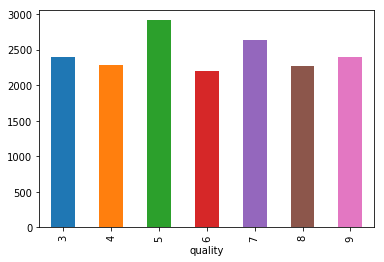

In [30]:
white_quality.plot('bar');

Теперь разница в данных не кается такой большой. Попробуем построить модель на этих данных(только сначала их перемешаем). 

In [31]:
X = white_wine_balanced.drop(['quality'], axis=1).values
y = white_wine_balanced['quality'].values

In [32]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)

In [33]:
knn_regression_best.fit(X_train, y_train);

In [34]:
knn_regression_best_predict = knn_regression_best.predict(X_test)

In [35]:
print("Ошибка прогноза для отложеной выборки после подборки параметров(mean square error) : ", mean_squared_error(y_test, knn_regression_best_predict))
print("Ошибка прогноза для отложеной выборки после подборки параметров(mean absolute error): ", mean_absolute_error(y_test, knn_regression_best_predict))

Ошибка прогноза для отложеной выборки после подборки параметров(mean square error) :  0.3552611641448579
Ошибка прогноза для отложеной выборки после подборки параметров(mean absolute error):  0.32028053769725306


Видно, что ошибка стала меньше приблизительно в два раза. Думаю, дальше стоит работать с сбалансированным набором данных. Теперь можно рассмотреть на этих данных задачу класификации.

In [36]:
knn_classifier = KNeighborsClassifier()
knn_grid_classifier = GridSearchCV(knn_classifier, KNNparam, cv=5, n_jobs=-1)

In [37]:
knn_grid_classifier.fit(X_train, y_train);

In [38]:
print(f'Лучшие параметры: {knn_grid_classifier.best_params_}')

Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 2}


In [39]:
metric = knn_grid_classifier.best_params_['metric']
n_neighbors = knn_grid_classifier.best_params_['n_neighbors']

In [40]:
knn_classifier_best = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

In [41]:
knn_classifier_best.fit(X_train, y_train);

In [42]:
knn_classifier_best_predict = knn_classifier_best.predict(X_test)

In [43]:
print('Accuracy score(KNN) = ', accuracy_score(y_test, knn_classifier_best_predict))

Accuracy score(KNN) =  0.8794077537502435


Видно, что если решать эту задачу как задачу класификации, подобрав лучшие параметры, то результат будет отличным. Попробую ещё пару методов.

In [44]:
SVC_classifier = SVC()
lmnn = LMNN(n_neighbors=n_neighbors)

In [45]:
%%time
SVC_classifier.fit(X_train, y_train)

CPU times: user 16.8 s, sys: 332 ms, total: 17.2 s
Wall time: 17.2 s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [46]:
%time
lmnn.fit(X_train, y_train)
knn_classifier_best.fit(lmnn.transform(X_train), y_train)

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 17.9 µs


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [47]:
%%time
svc_predict = SVC_classifier.predict(X_test)

CPU times: user 4.14 s, sys: 90.6 ms, total: 4.23 s
Wall time: 4.12 s


In [48]:
%%time
knn_lmnn_predict = knn_classifier_best.predict(X_test)

CPU times: user 136 ms, sys: 1.52 ms, total: 138 ms
Wall time: 137 ms


In [49]:
print("Accuracy_score (SVC) = ", accuracy_score(y_test, svc_predict))
print("Accuracy_score (KNN with LMNN transformation) = ", accuracy_score(y_test, knn_lmnn_predict))

Accuracy_score (SVC) =  0.880187025131502
Accuracy_score (KNN with LMNN transformation) =  0.12546269238262225


Такой результат можно считать очень даже хорошим. Проверим два алгоритма, что дали нам наилучший результат на выборке для красного вина. (Сначала её тоже нужно сбалансировать)

In [50]:
red_quality = red_wine['quality'].groupby(red_wine['quality']).count()

In [51]:
red_quality

quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64

In [52]:
red3=red_wine[red_wine['quality']==3]
red3=pd.concat([red3]*68)
red4=red_wine[red_wine['quality']==4]
red4=pd.concat([red4]*13)
red5=red_wine[red_wine['quality']==5]
red6=red_wine[red_wine['quality']==6]
red7=red_wine[red_wine['quality']==7]
red7=pd.concat([red7]*3)
red8=red_wine[red_wine['quality']==8]
red8=pd.concat([red8]*36)
red_wine_balanced = pd.concat([red3, red4, red5, red6, red7, red8])

In [53]:
red_quality = red_wine_balanced['quality'].groupby(red_wine['quality']).count()

In [54]:
red_quality

quality
3    680
4    689
5    681
6    638
7    597
8    648
Name: quality, dtype: int64

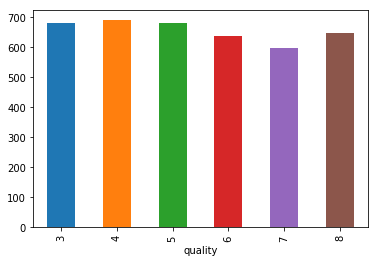

In [55]:
red_quality.plot('bar');

Теперь данные выглядят хорошо, можно пробовать строить модели. 

In [56]:
X = red_wine_balanced.drop(['quality'], axis=1).values
y = red_wine_balanced['quality'].values

In [57]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)

In [58]:
%time
SVC_classifier.fit(X_train, y_train);

CPU times: user 6 µs, sys: 4 µs, total: 10 µs
Wall time: 17.6 µs


In [59]:
%%time
svc_predict = SVC_classifier.predict(X_test)

CPU times: user 239 ms, sys: 0 ns, total: 239 ms
Wall time: 237 ms


In [60]:
knn_grid_classifier.fit(X_train, y_train);

In [61]:
print(f'Лучшие параметры: {knn_grid_classifier.best_params_}')

Лучшие параметры: {'metric': 'euclidean', 'n_neighbors': 2}


In [62]:
metric = knn_grid_classifier.best_params_['metric']
n_neighbors = knn_grid_classifier.best_params_['n_neighbors']

In [63]:
knn_classifier_best = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

In [64]:
%%time
knn_classifier_best.fit(X_train, y_train);

CPU times: user 5 ms, sys: 642 µs, total: 5.64 ms
Wall time: 4.94 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [65]:
%%time
knn_classifier_best_predict = knn_classifier_best.predict(X_test)

CPU times: user 25.6 ms, sys: 1.04 ms, total: 26.7 ms
Wall time: 26.9 ms


In [66]:
print("Accuracy_score (SVC) = ", accuracy_score(y_test, svc_predict))
print("Accuracy_score (KNN with find best parametrs) = ", accuracy_score(y_test, knn_classifier_best_predict))

Accuracy_score (SVC) =  0.8067796610169492
Accuracy_score (KNN with find best parametrs) =  0.823728813559322


Наглядно видно, что всё зависит от модели, которую мы выбираем. На наборе для белого вина лучше сработала модель SVC в то время, как для красного вина лучше сработал метод ближайших соседей.